In [1]:
# Exchange fluxes above the sill
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [20]:
sd = 9 # Sill depth
file1 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-only-hourly/state_' + str(format(sd,'03d')) + '.nc')
state1 = file1.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40)) # Remove the boundary walls and the shelf region
grid1 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-only-hourly/grid_' + str(format(sd,'03d')) + '.nc')
file2 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/state_' + str(format(sd,'03d')) + '.nc')
state2 = file2.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40)) # Remove the boundary walls and the shelf region
grid2 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/grid_' + str(format(sd,'03d')) + '.nc')

time = state2.T.data / 3600
xs = 72
u1 = state1.U.data[:,:,:,xs]
u2 = state2.U.data[:,:,:,xs]

Area = np.empty([50, 9]) # Cross Y direction
Area[:10, :] = 100
Area[10:20, :] = 200
Area[20:30, :] = 300
Area[30:40, :] = 800
Area[40:, :] = 1600

HFacW = grid2.HFacW.data[:,30:39,xs] # vertical fraction of open cell at West face
state1.Xp1.data[72], state1.X.data[71]

(5803.325828523144, 5793.303473090398)

In [3]:
Q1out = np.empty(len(time))
Q2out = np.empty(len(time))
Q1in = np.empty(len(time))
Q2in = np.empty(len(time))
for t in range(len(time)):
    Q1 = u1[t,:,:] * Area * HFacW
    Q2 = u2[t,:,:] * Area * HFacW
    Q1out[t] = Q1[Q1 > 0].sum()
    Q2out[t] = Q2[Q2 > 0].sum()
    Q1in[t] = Q1[Q1 < 0].sum()
    Q2in[t] = Q2[Q2 < 0].sum()

np.mean(Q2out[10:]+Q2in[10:])

683.396994812112

Text(0, 0.5, 'Volume flux ($m^3/s$)')

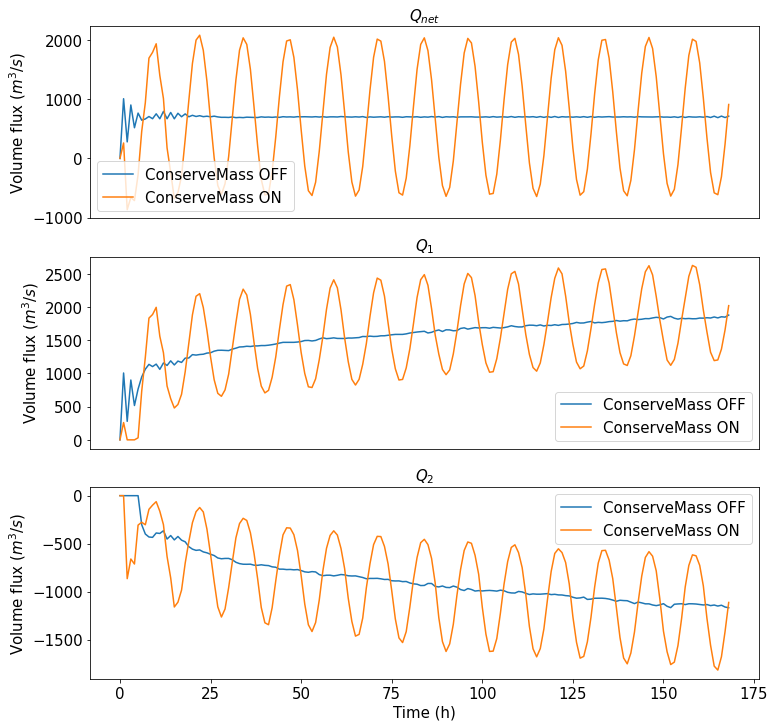

In [4]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/VolumeTest/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,12)) 
ax1.plot(time,Q1in+Q1out, label='ConserveMass OFF')
ax1.plot(time,Q2in+Q2out, label='ConserveMass ON')
ax1.set_title('$Q_{net}$', size=15, weight='bold')
ax1.legend(loc = 'best', fontsize=15)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_visible(False)
ax1.set_ylabel('Volume flux ($m^3/s$)', size=15)


ax2.plot(time,Q1out, label='ConserveMass OFF')
ax2.plot(time,Q2out, label='ConserveMass ON')
ax2.set_title('$Q_1$', size=15, weight='bold')
ax2.legend(loc = 'best', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.xaxis.set_visible(False)
ax2.set_ylabel('Volume flux ($m^3/s$)', size=15)


ax3.plot(time,Q1in, label='ConserveMass OFF')
ax3.plot(time,Q2in, label='ConserveMass ON')
ax3.set_title('$Q_2$', size=15, weight='bold')
ax3.legend(loc = 'best', fontsize=15)
ax3.tick_params(labelsize=15)

ax3.set_xlabel('Time (h)', size=15)
ax3.set_ylabel('Volume flux ($m^3/s$)', size=15)


In [ ]:
fig.savefig(fig_path + '/ExchangeFlux.png', dpi = 200, bbox_inches='tight')